# General informations

In [ ]:
## CHA-AIPH Project
# -*- coding: utf-8 -*-

"""
Created on Tue Jan 5 2021
@author: Tisseaux Antoine

This script is used to predict survival at hospital discharge for ICU patients
ML model used: Adaboost
"""

'\nCreated on Tue Jan 5 2021\n@author: Tisseaux Antoine\n\nThis script is used to predict survival at hospital discharge for ICU patients\nML model used: Adaboost\n'

# set environement

Importing packages

In [ ]:
# Importing libraries:

from joblib import dump, load
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt

Importing files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



loading csv files

In [ ]:
my_df_all_patients = pd.read_csv('/content/drive/MyDrive/CHAIPH_PROJECT_GR2/data/final_dataframes/my_df_survival_preprocess', sep=",")

setting options for pandas

In [ ]:
# Displaying option: all columns
pd.set_option('display.max_columns', None)

setting a random seed:

In [ ]:
# setting random seed
SEED = 25

# Creating train and test datasets:

In [ ]:
# creating a vector y with the outcome:
y = my_df_all_patients["hospital_death"]

# creating a dataset X with the variables used for the prediction
X = my_df_all_patients.drop('hospital_death', axis=1)

## splitting the data into train set and test set:

80% for training, 20% for testing : (test_size = 0.2)

we stratify on outcome

In [ ]:
# splitting scaled data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

Data augmentation

In [ ]:
ros = RandomOverSampler(random_state=SEED)

X_train, y_train = ros.fit_resample(X_train, y_train)

print(sorted(Counter(y_train).items()))

[(0.0, 12580), (1.0, 12580)]


## vizualizing splitting:

train dataset:

In [ ]:
# training dataset size:
print("Nb of patients in training set is %i\n" % X_train.shape[0])
proportion_train = y_train.value_counts() / y_train.count()

# displaying number of patients with CKD and without CKD in the training set
print(f"Nb of patients dead at hospital discharge is {y_train.value_counts()[0]} "
      f"representing {proportion_train[0]} % of training dataset")
print(f"Nb of patients alive at hospital discharge is {y_train.value_counts()[1]} "
      f"representing {proportion_train[1]} % of training dataset\n")

Nb of patients in training set is 25160

Nb of patients dead at hospital discharge is 12580 representing 0.5 % of training dataset
Nb of patients alive at hospital discharge is 12580 representing 0.5 % of training dataset



test dataset:

In [ ]:
# test dataset size:
print("Nb of patients in test set is %i\n" % X_test.shape[0])
proportion_test = y_test.value_counts() / y_test.count()

# displaying number of patients with CKD and without CKD in the test set
print(f"Nb of patients dead at hospital discharge is {y_test.value_counts()[0]} "
      f"representing {proportion_test[0]} % of test dataset")
print(f"Nb of patients dead at hospital discharge is {y_test.value_counts()[1]} "
      f"representing {proportion_test[1]} % of test dataset\n")

Nb of patients in test set is 3720

Nb of patients dead at hospital discharge is 3146 representing 0.8456989247311828 % of test dataset
Nb of patients dead at hospital discharge is 574 representing 0.1543010752688172 % of test dataset



# Tuning hyperparameters :

## Grid search CrossValidation:



possible hyperparameters:

In [ ]:
# possible hyperparameters for adaboost classifier:
#   # base_estimator: base learner used by adaboosting algorithm, decision tree by default
#   # n_estimators: maximum number of estimators (models) to train sequentially
#   # learning_rate: determines the weight applied to each estimator in the boosting process

# Set all the combinaisons hyperpameters to be tested:
# we use shrinkage for better generalization
tuned_parameters = {'learning_rate' :[0.4, 0.5, 0.6], "n_estimators": [400, 500, 600]}

running grid search:

In [ ]:
# Using GridSearchCV function to explore an estimator for multiple values of hyperameters
# We specify the estimator to use and all the hyperparameters in the variable 'tuned_parameters':
# GridSearchCV will compute a given score for each combinaison of hyperparameters
# We will compute for F1 score

ada_clf_grid = GridSearchCV(AdaBoostClassifier(random_state=SEED, base_estimator= None, algorithm='SAMME.R'), 
                            tuned_parameters, scoring='f1', n_jobs=-1, cv=5, verbose=2)

# we train the adaboost estimators:
ada_clf_grid.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()

# We print the best combinaison of hyperpameters founded
print(ada_clf_grid.best_params_)
print()


print("Grid scores on development set:")
print()

# we will display the mean and the standard deviation of F1-score for
# all the combinaisons of hyperparameters tested with grid search:
means = ada_clf_grid.cv_results_['mean_test_score']
stds = ada_clf_grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, ada_clf_grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()

y_true, ada_grid_y_pred = y_test, ada_clf_grid.predict(X_test)
print(classification_report(y_true, ada_grid_y_pred))
print()

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters set found on development set:

{'learning_rate': 0.6, 'n_estimators': 600}

Grid scores on development set:

0.747 (+/-0.010) for {'learning_rate': 0.4, 'n_estimators': 400}
0.747 (+/-0.010) for {'learning_rate': 0.4, 'n_estimators': 500}
0.750 (+/-0.011) for {'learning_rate': 0.4, 'n_estimators': 600}
0.748 (+/-0.013) for {'learning_rate': 0.5, 'n_estimators': 400}
0.750 (+/-0.012) for {'learning_rate': 0.5, 'n_estimators': 500}
0.753 (+/-0.014) for {'learning_rate': 0.5, 'n_estimators': 600}
0.749 (+/-0.013) for {'learning_rate': 0.6, 'n_estimators': 400}
0.751 (+/-0.015) for {'learning_rate': 0.6, 'n_estimators': 500}
0.753 (+/-0.014) for {'learning_rate': 0.6, 'n_estimators': 600}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.93      0.77     

# building the best Adaboost model:

In [ ]:
# We declare the logistic regression estimator:
ada_clf = ada_clf_grid

# Performance evaluation:

## Confusion Matrix

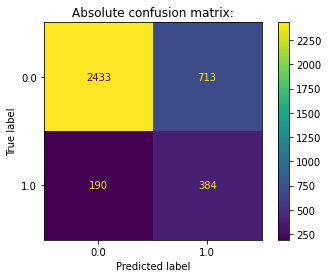

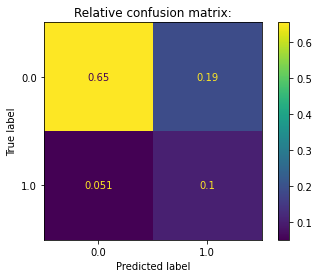

In [ ]:
# displaying absolute confusion matrix:
disp = ConfusionMatrixDisplay.from_predictions(y_test, ada_grid_y_pred, display_labels=ada_clf.classes_)
plt.title("Absolute confusion matrix:")
plt.show()

# displaying relative confusion matrix:
disp = ConfusionMatrixDisplay.from_predictions(y_test, ada_grid_y_pred, display_labels=ada_clf.classes_, normalize='all')
plt.title("Relative confusion matrix:")
plt.show()

## Performance scores

In [ ]:
# performance scores
print('accuracy score: %f\n' % accuracy_score(y_test, ada_grid_y_pred))
print('f1_score: %f\n' % f1_score(y_test, ada_grid_y_pred, average='weighted'))
print('recall score: %f\n' % recall_score(y_test, ada_grid_y_pred, average='weighted'))
print('precision score: %f\n' % precision_score(y_test, ada_grid_y_pred, average='weighted'))

accuracy score: 0.757258

f1_score: 0.784242

recall score: 0.757258

precision score: 0.838452



## ROC curve

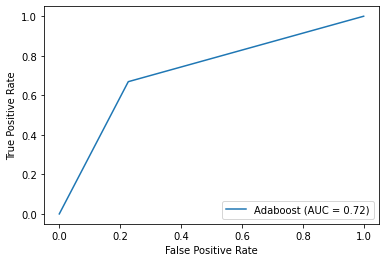


roc_auc score: 0.7211762738370278


In [ ]:
# displaying ROC curve:
fpr, tpr, thresholds = metrics.roc_curve(y_test, ada_grid_y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(tpr=tpr, fpr=fpr, roc_auc=roc_auc, estimator_name="Adaboost")
display.plot()
plt.show()

print('\nroc_auc score:', metrics.roc_auc_score(y_test, ada_grid_y_pred, average='weighted'))

## saving model:

In [ ]:
dump(ada_clf, '/content/drive/MyDrive/CHAIPH_PROJECT_GR2/scripts/models/ada.joblib') 

['/content/drive/MyDrive/CHAIPH_PROJECT_GR2/scripts/models/ada.joblib']